In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import pyrex
#import pyrex.custom.ara as ara
from pyrex.internal_functions import normalize
import os
import sys
import seaborn as sns
import polReco_util as util
import scipy

import ROOT
from ROOT import TCanvas, TGraph
from ROOT import gROOT
from ROOT import gInterpreter, gSystem
from ROOT import TChain, TSelector, TTree
from scipy.stats import norm
from scipy.stats import rayleigh

#add headers from AraSim. Not sure if all of them are needed, and I'm lazy to check that. MAK SURE to change the location of the headers
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/Position.h"')
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/Report.h"')
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/Detector.h"')
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/Settings.h"')
gInterpreter.ProcessLine('#include "/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/libRootFftwWrapper/include/FFTtools.h"')


gSystem.Load('/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/AraSim/libAra.so') #load the simulation event library. You might get an error asking for the eventSim dictionry. To solve that, go to where you compiled AraSim, find that file, and copy it to where you set LD_LIBRARY_PATH.
gSystem.Load('/cvmfs/ara.opensciencegrid.org/trunk/centos7/ara_build/lib/libAraEvent.so')
gSystem.Load("/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/libRootFftwWrapper/build/libRootFftwWrapper.so")

sys.path.append("/cvmfs/ara.opensciencegrid.org/trunk/centos7/source/ARA_cvmfs/root_build/lib/") # go to parent dir
#sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")  #I don't have access to this directory in Jorge's account
#sys.path.append("/users/PAS0654/jflaherty13/.local/lib/python3.9/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
# import math
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
#import matplotlib as mpl
#import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
#import itertools

# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
#mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

# import mplcyberpunk
# plt.style.use("cyberpunk")

#current_palette = sns.color_palette('colorblind', 10)
current_palette = sns.color_palette('bright', 10)

/cvmfs/ara.opensciencegrid.org/trunk/centos7/root_build/lib/cppyy/__init__.py:72: DeprecationWarning: invalid escape sequence \d
  if re.match('^libcppyy_backend\d_\d$', lib_name):


Welcome to JupyROOT 6.22/06


Warning in <TClassTable::Add>: class FFTtools::AnalyticSignal already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CompositeSignal already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::BandlimitedSampledSignal already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::ThermalNoise already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::Averager already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT::MotherWavelet already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT::Ricker already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT::Ridger already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::CWT::Morlet already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::DigitalFilter already in TClassTable
Warning in <TClassTable::Add>: class FFTtools::DigitalFilterSeries already in T

In [2]:
#TODO: Include runs 12557 12558 12559 12575 12576 12577 12599 12600 12601 all in one set of plots.
gainBalance = False
deconvolution = False
station = 2
if (station == 1):
    runNumbers = [13229, 13230, 13231, 13248, 13249, 13250, 13275, 13276]
elif (station == 2):
    # runNumbers = [12557, 12558, 12559, 12575, 12576, 12577, 12599, 12600, 12601]
    # runNumbers = [12557, 12558, 12559, 12575, 12576, 12577]
    # runNumbers = [0, 15, 30, 45, 60, 75, 90]
    runNumbers = range(0,91)
    
# srcFolder = "newPolRecoV34/A"+str(station)+"/"
# srcFolder = "newPolRecoV38/A"+str(station)+"/"
srcFolder = "newPolRecoV38/alisaIdlNoiseSubtracted/A"+str(station)+"/"
pathList = []

#Import RF data
for run in runNumbers:
    tempPath = srcFolder + "run_0" + str(run) + "/"
    tempPath += "rfEvents/"
    if (not deconvolution):
        tempPath += "noDeconvolution/"
        deconvolutionLabel = "No Deconvolution"
    else:
        tempPath += "deconvolution/"
        deconvolutionLabel = "With Deconvolution"
    if (gainBalance):
        tempPath += "gainCorrection/"
        gainLabel = "With Gain Balancing"
    else:
        gainLabel = "No Gain Balancing"
    
    pathList.append(tempPath)


appended_data = []
sortedFiles = []

for path in pathList:
    # if (path == pathList[0]):
    fileList = []
    print("Parsing reco files in " + path + "...")
    for filename in os.listdir(path):#Loop over desired directory    
            if (filename.startswith("polReco_run")): #extension, .pkl in this case
                fileList.append(filename)
                
    for filename in sorted(fileList):
            name = os.path.join(path, str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)            

print("Concatenating data...")
polRF = pd.concat(appended_data) 
totalRFEvents = len(polRF)
print("Total number of RF events: " + str(totalRFEvents))

Parsing reco files in newPolRecoV38/alisaIdlNoiseSubtracted/A2/run_00/rfEvents/noDeconvolution/...
Parsing reco files in newPolRecoV38/alisaIdlNoiseSubtracted/A2/run_01/rfEvents/noDeconvolution/...
Parsing reco files in newPolRecoV38/alisaIdlNoiseSubtracted/A2/run_02/rfEvents/noDeconvolution/...
Parsing reco files in newPolRecoV38/alisaIdlNoiseSubtracted/A2/run_03/rfEvents/noDeconvolution/...
Parsing reco files in newPolRecoV38/alisaIdlNoiseSubtracted/A2/run_04/rfEvents/noDeconvolution/...
Parsing reco files in newPolRecoV38/alisaIdlNoiseSubtracted/A2/run_05/rfEvents/noDeconvolution/...
Parsing reco files in newPolRecoV38/alisaIdlNoiseSubtracted/A2/run_06/rfEvents/noDeconvolution/...
Parsing reco files in newPolRecoV38/alisaIdlNoiseSubtracted/A2/run_07/rfEvents/noDeconvolution/...
Parsing reco files in newPolRecoV38/alisaIdlNoiseSubtracted/A2/run_08/rfEvents/noDeconvolution/...
Parsing reco files in newPolRecoV38/alisaIdlNoiseSubtracted/A2/run_09/rfEvents/noDeconvolution/...
Parsing re

In [3]:
# #Import softtrigger data
# pathList = []
# for run in runNumbers:
#     tempPath = srcFolder + "run_0" + str(run) + "/"
#     tempPath += "softTriggerEvents/"
#     if (not deconvolution):
#         tempPath += "noDeconvolution/"
#         deconvolutionLabel = "No Deconvolution"
#     else:
#         tempPath += "deconvolution/"
#         deconvolutionLabel = "With Deconvolution"
#     if (gainBalance):
#         tempPath += "gainCorrection/"
#         gainLabel = "With Gain Balancing"
#     else:
#         gainLabel = "No Gain Balancing"
    
#     pathList.append(tempPath)


# appended_data = []
# sortedFiles = []

# for path in pathList:
#     # if (path == pathList[0]):
#     fileList = []
#     print("Parsing reco files in " + path + "...")
#     for filename in os.listdir(path):#Loop over desired directory    
#             if (filename.startswith("polReco_run")): #extension, .pkl in this case
#                 fileList.append(filename)
                
#     for filename in sorted(fileList):
#             name = os.path.join(path, str(filename))
#             data = pd.read_pickle(name)
#             appended_data.append(data)            

# print("Concatenating data...")
# polSoft = pd.concat(appended_data) 
# totalSoftTriggerEvents = len(polSoft)
# print("Total number of soft-trigger events: " + str(totalSoftTriggerEvents))

In [4]:
# #Import calpulser data
# pathList = []
# for run in runNumbers:
#     tempPath = srcFolder + "run_0" + str(run) + "/"
#     tempPath += "calpulserEvents/"
#     if (not deconvolution):
#         tempPath += "noDeconvolution/"
#         deconvolutionLabel = "No Deconvolution"
#     else:
#         tempPath += "deconvolution/"
#         deconvolutionLabel = "With Deconvolution"
#     if (gainBalance):
#         tempPath += "gainCorrection/"
#         gainLabel = "With Gain Balancing"
#     else:
#         gainLabel = "No Gain Balancing"
    
#     pathList.append(tempPath)


# appended_data = []
# sortedFiles = []

# for path in pathList:
#     # if (path == pathList[0]):
#     fileList = []
#     print("Parsing reco files in " + path + "...")
#     for filename in os.listdir(path):#Loop over desired directory    
#             if (filename.startswith("polReco_run")): #extension, .pkl in this case
#                 fileList.append(filename)
                
#     for filename in sorted(fileList):
#             name = os.path.join(path, str(filename))
#             data = pd.read_pickle(name)
#             appended_data.append(data)            

# print("Concatenating data...")
# polCal = pd.concat(appended_data) 
# totalCalpulserEvents = len(polCal)
# print("Total number of calpulser events: " + str(totalCalpulserEvents))

In [5]:
#Make function that easily converts pandas structure to numpy array.
def pandasToNumpy(pandaFrame):
    return np.array(pandaFrame.tolist())

In [6]:
# #Initialize Mask and cuts for RF events
# mask = np.ones(totalRFEvents).astype(bool)

# snrCutoff = 5

# #Apply cuts.
# mask *= pandasToNumpy(polRF.pulserDepth) > 650 #Events where pulser depth > 650 meters
# mask *= np.all(pandasToNumpy(polRF.thetaReco)>90, axis=1) #Upgoing events only
# mask *= pandasToNumpy(polRF.vSNR) > snrCutoff #SNR > 5 cut
# mask *= np.invert(np.any(pandasToNumpy(polRF.peakTimes)[:,8:].astype(int) == 0, axis=1)) #Cut events where we set HPol peak time to zero.
# polRFCut = polRF.loc[mask]
# len(polRFCut)

In [7]:
# #Initialize Mask and cuts for soft-trigger events
# mask = np.ones(totalSoftTriggerEvents).astype(bool)

# # snrCutoff = 5

# #Apply cuts.
# mask *= pandasToNumpy(polSoft.pulserDepth) > 650 #Events where pulser depth > 650 meters
# # mask *= np.all(pandasToNumpy(polSoft.thetaReco)>90, axis=1) #Upgoing events only
# # mask *= pandasToNumpy(polSoft.vSNR) > snrCutoff #SNR > 5 cut
# mask *= np.invert(np.any(pandasToNumpy(polSoft.peakTimes)[:,8:].astype(int) == 0, axis=1)) #Cut events where we set HPol peak time to zero.
# polSoftCut = polSoft.loc[mask]
# len(polSoftCut)

In [8]:
# #Initialize Mask and cuts for calpulser events
# mask = np.ones(totalCalpulserEvents).astype(bool)

# # snrCutoff = 5

# #Apply cuts.
# mask *= pandasToNumpy(polCal.pulserDepth) > 650 #Events where pulser depth > 650 meters
# # mask *= np.all(pandasToNumpy(polSoft.thetaReco)>90, axis=1) #Upgoing events only
# mask *= pandasToNumpy(polCal.vSNR) > snrCutoff #SNR > 5 cut
# mask *= np.invert(np.any(pandasToNumpy(polCal.peakTimes)[:,8:].astype(int) == 0, axis=1)) #Cut events where we set HPol peak time to zero.
# polCalCut = polCal.loc[mask]
# len(polCalCut)

In [9]:
#TODO: Rewrite the plotting code to stick with pandas dataframe, as my numpy array method is tedious and getting bloated.
#Write plotting function for deltaT's of Keith's timing cut.
#TODO:  Need to implement SNR cut somehow.

def plotDeltaT(pol,mask=None, bins=None, snrCutoff=None):
    fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(12,12),sharex=True, sharey=True)
    fig.supxlabel("$\\Delta t$ [ns]")
    fig.supylabel("Number of Events")
    timingChannels = np.array(pol.timingChannels.to_numpy()[0]).astype(int)
    timingMeasured = np.array(pol.timingDifferenceMeasured.to_numpy().tolist())
    timingExpected = np.array(pol.timingDifferenceExpected.to_numpy().tolist())
    if (mask is None):
        mask = np.ones(len(pol)).astype(bool)
    if (bins is None):
        bins = 10
    if (snrCutoff is not None):
        snrMean = np.array(pol.SNR.to_numpy().tolist())[:,timingChannels].mean(axis=1)
        mask *= snrMean > snrCutoff
    import itertools
    combinations = []
    for combination in itertools.combinations(timingChannels, 2):
        combinations.append(combination)
    combinations = np.array(combinations).astype(str)
    fig.suptitle("Comparison of $\\Delta t$ Across A2 Runs " + str(runNumbers) + " Between Channels " + str(timingChannels) + " N = " +str(len(pol)))
    i=0
    for axes in ax.flatten():
        if (i<3):
            axes.hist(timingMeasured[:,i][mask]*1e9, bins=bins)
            axes.set_title("$\\Delta t_{"+combinations[i,0]+combinations[i,1]+ "}$ Measured")
        else:
            axes.hist(timingExpected[:,i-3][mask]*1e9, bins=bins)
            axes.set_title("$\\Delta t_{"+combinations[i-3,0]+combinations[i-3,1]+ "}$ Expected")
        i+=1
    return fig, ax

In [10]:
# plotDeltaT(polRF)

In [11]:
# fig, ax = plotDeltaT(polRFCut, snrCutoff=5, bins=range(-100,100,5))

# timingWindows = np.array([[-20,-10],[20,50],[40,65]])

# # for i in range(3):
# #     for j in range(2):
# #         ax[0,i].axvline(timingWindows[i,j], color='black', linestyle='--', label = str(timingWindows[i,j]))
# #     ax[0,i].legend()

# ax[0,0].axvline(-42,color='black')
# ax[0,0].axvline(-28,color='black')

In [12]:
def makeHistogram(pol, perChannel=True, bins=None, badChannels=None):
    #Get shape of dataframe and set up subplots
    numpyFrame = pandasToNumpy(pol)
    frameShape = numpyFrame.shape[1]
    figsize = (16,16)
    channelLabels = []
    
    if (perChannel):
        if (frameShape == 8):
            nrows = 2
            ncols = 4
            figsize = (figsize[0], int(figsize[1]/2))
            for ch in range(frameShape):
                channelLabels.append('Ch. ' + str(ch) + '/' + str(ch+8))
                
        elif (frameShape == 16):
            nrows = 4
            ncols = 4
            for ch in range(frameShape):
                channelLabels.append('Ch. ' + str(ch))
    else:
        nrows = 1
        ncols = 1
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize,sharex=True, sharey=True)
    channelLabels = np.array(channelLabels)
    if (perChannel):
        ax = ax.ravel()
        for channel, axes in zip(range(frameShape),ax):
            color='#1f77b4'
            label=None
            if badChannels is not None:
                if channel in badChannels:
                    color = 'red'
                    label = 'Bad Channel'
                else:
                    color='#1f77b4'
                    label = None
            axes.hist(numpyFrame[:,channel], bins = bins, color=color, label=label)
            axes.set_title(channelLabels[channel])
            axes.legend()
    else:
        mask = np.ones(numpyFrame.shape[1]).astype(bool)
        if badChannels is not None:
            for index in range(numpyFrame.shape[1]):
                if index%8 in badChannels:
                    mask[index] = False
        ax.hist(numpyFrame[:,mask].flatten(), bins = bins)
    return fig, ax

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Text(0.5, 0.01, '$\\Psi_{Reco}$ [degrees]')

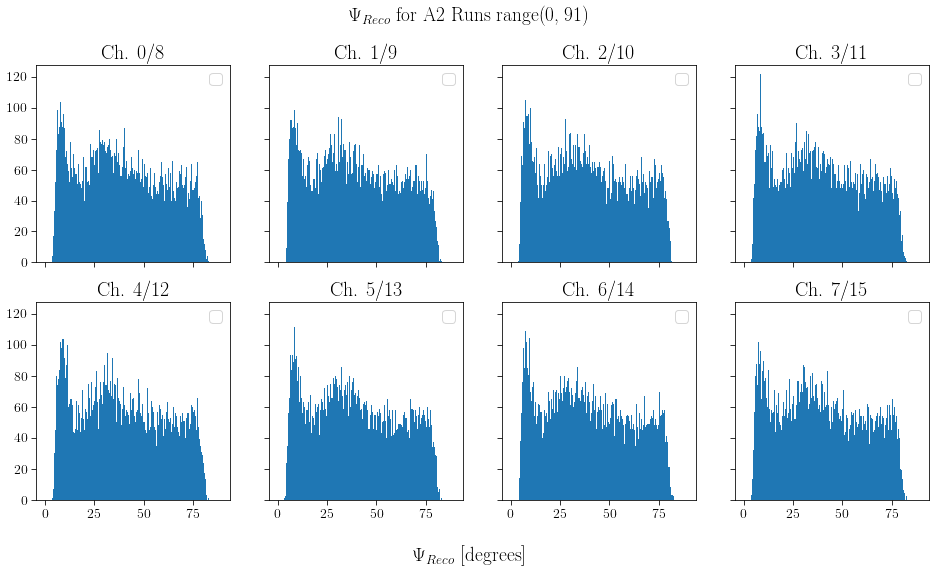

In [13]:
fig, ax = makeHistogram(polRF.psiReco, bins=np.arange(0,90,0.5))
fig.suptitle('$\\Psi_{Reco}$ for A' + str(station) + " Runs " + str(runNumbers))
fig.supxlabel("$\\Psi_{Reco}$ [degrees]")

In [14]:
# fig, ax = makeHistogram(polRF.psiReco, bins=np.arange(0,20,0.5), badChannels=[5,7], perChannel=False)
# fig.suptitle('$\\Psi_{Reco}$ for A' + str(station) + " Runs " + str(runNumbers))
# fig.supxlabel("$\\Psi_{Reco}$ [degrees]")

In [15]:
# fig, ax = makeHistogram(polRFCut.psiRecoSoftTriggerHpol, bins=np.arange(0,20,0.5), badChannels=[5,7])
# fig.suptitle('$\\Psi_{Reco}$ with HPol from Soft-Trigger for A' + str(station) + " Runs " + str(runNumbers) + " $|$ SNR $>$ " + str(snrCutoff) + " $|$ N = " + str(len(polRFCut)))
# fig.supxlabel("$\\Psi_{Reco}$ [degrees]")

In [16]:
# fig, ax = makeHistogram(polRFCut.hilbertPeaksSoftTriggerHpol, bins=60, badChannels=[5,7])
# fig.suptitle('Hilbert Peaks with HPol from Soft-Trigger for A' + str(station) + " Runs " + str(runNumbers) + " $|$ SNR $>$ " + str(snrCutoff) + " $|$ N = " + str(len(polRFCut)))
# fig.supxlabel("Hilbert Peaks [mV]")

In [17]:
# fig, ax = makeHistogram(polRFCut.hilbertPeaks, badChannels=[5,7], bins=np.arange(0,2000,50))
# fig.suptitle('Hilbert Peaks for A' + str(station) + " Runs " + str(runNumbers) + " $|$ SNR $>$ " + str(snrCutoff) + " $|$ N = " + str(len(polRFCut)))
# fig.supxlabel("Hilbert Peaks [mV]")

In [18]:
# fig, ax = makeHistogram(polRFCut.loc[pandasToNumpy(polRFCut.psiRecoSoftTriggerHpol)[:,0] < 1].psiRecoSoftTriggerHpol, bins=np.arange(0,20,0.5), badChannels=[5,7])
# fig.suptitle('$\\Psi_{Reco}$ with HPol from Soft-Trigger for A' + str(station) + " Runs " + str(runNumbers) + " $|$ SNR $>$ " + str(snrCutoff) + " $|$ N = " + str(len(polRFCut)))
# fig.supxlabel("$\\Psi_{Reco}$ [degrees]")

In [19]:
# fig, ax = makeHistogram(polRFCut.psiReco, bins=range(0,20,1), perChannel=False)
# fig.suptitle('$\\Psi_{Reco}$ for A' + str(station) + " Runs " + str(runNumbers) + " $|$ SNR $>$ " + str(snrCutoff) + " $|$ N = " + str(len(polRFCut)))
# fig.supxlabel("$\\Psi_{Reco}$ [degrees]")

In [20]:
# minWindow = -20-14.1
# maxWindow = 10-14.1
# fig, ax = makeHistogram(polRFCut.deltaTPeaks, bins=60, badChannels=[5,7])
# fig.suptitle('$\\Delta t_{HV}$ for A' + str(station) + " Spice Events in Runs " + str(runNumbers) + " $|$ SNR $>$ " + str(snrCutoff) + " $|$ N = " + str(len(polRFCut)))
# fig.supxlabel("$\\Delta t_{HV}$ [degrees]")
# for axes in ax.flatten():
#     axes.axvline(minWindow, color='black', linestyle='--', alpha=0.7, label = str(minWindow) + "ns")
#     axes.axvline(maxWindow, color='black', linestyle='--', alpha=0.7, label = str(maxWindow) + "ns")
#     axes.legend()

In [21]:
# minWindow = -20-14.1
# maxWindow = 10-14.1
# fig, ax = makeHistogram(polRFCut.loc[pandasToNumpy(polRFCut.deltaTPeaks)[:,1]>-7].deltaTPeaks, bins=np.arange(minWindow,maxWindow,0.5), badChannels=[5,7])
# fig.suptitle('$\\Delta t_{HV}$ for A' + str(station) + " Spice Events in Runs " + str(runNumbers) + " $|$ SNR $>$ " + str(snrCutoff) + " $|$ N = " + str(len(polRFCut)))
# fig.supxlabel("$\\Delta t_{HV}$ [degrees]")
# for axes in ax.flatten():
#     axes.axvline(minWindow, color='black', linestyle='--', alpha=0.7, label = str(minWindow) + "ns")
#     axes.axvline(maxWindow, color='black', linestyle='--', alpha=0.7, label = str(maxWindow) + "ns")
#     axes.legend()

In [22]:
# minWindow = -20-14.1
# maxWindow = 10-14.1
# fig, ax = makeHistogram(polRFCut.deltaTPeaksSoftHpol, bins=60)
# fig.suptitle('$\\Delta t_{HV}$ for A' + str(station) + " Runs " + str(runNumbers) + " $|$ SNR $>$ " + str(snrCutoff) + " $|$ N = " + str(len(polRFCut)))
# fig.supxlabel("$\\Delta t_{HV}$ [degrees]")
# for axes in ax.flatten():
#     axes.axvline(minWindow, color='black', linestyle='--', alpha=0.7, label = str(minWindow) + "ns")
#     axes.axvline(maxWindow, color='black', linestyle='--', alpha=0.7, label = str(maxWindow) + "ns")
#     axes.legend()

In [23]:
# minWindow = -20-14.1
# maxWindow = 10-14.1
# fig, ax = makeHistogram(polSoftCut.deltaTPeaks, bins=60, badChannels=[5,7])
# fig.suptitle('$\\Delta t_{HV}$ for A' + str(station) + " Soft-Trigger Events in Runs " + str(runNumbers) + " $|$ N = " + str(len(polSoftCut)))
# fig.supxlabel("$\\Delta t_{HV}$ [degrees]")
# for axes in ax.flatten():
#     axes.axvline(minWindow, color='black', linestyle='--', alpha=0.7, label = str(minWindow) + "ns")
#     axes.axvline(maxWindow, color='black', linestyle='--', alpha=0.7, label = str(maxWindow) + "ns")
#     axes.legend()

In [24]:
# minWindow = -20-14.1
# maxWindow = 10-14.1
# fig, ax = makeHistogram(polCalCut.deltaTPeaks, bins=60, badChannels=[5,7])
# fig.suptitle('$\\Delta t_{HV}$ for A' + str(station) + " Calpulser Events in Runs " + str(runNumbers) + " $|$ SNR $>$ " + str(snrCutoff) + " $|$ N = " + str(len(polCalCut)))
# fig.supxlabel("$\\Delta t_{HV}$ [degrees]")
# for axes in ax.flatten():
#     axes.axvline(minWindow, color='black', linestyle='--', alpha=0.7, label = str(minWindow) + "ns")
#     axes.axvline(maxWindow, color='black', linestyle='--', alpha=0.7, label = str(maxWindow) + "ns")
#     axes.legend()

In [25]:

# from matplotlib.backends.backend_pdf import PdfPages
# pp = PdfPages('highDeltaTEvents.pdf')
# pol = polRFCut.loc[pandasToNumpy(polRFCut.deltaTPeaks)[:,1]>-7]
# keptRuns = np.unique(pandasToNumpy(pol.runNumber)).astype(int)
# for run in keptRuns:
#     rawSrcFolder = "../ARA_Reconstruction/data/A"+str(station)+"/run_0"+str(int(run))
#     rawFilename = rawSrcFolder + "/event0"+str(int(run))+".root"
#     keptEvents = pandasToNumpy(pol.loc[pol.runNumber == run].eventNumber).astype(int)
    
#     print(rawFilename)
#     rawInputFile = ROOT.TFile.Open(rawFilename)
#     eventTree = rawInputFile.Get("eventTree")
#     rawEvent = ROOT.RawAtriStationEvent()
#     eventTree.SetBranchAddress("event",ROOT.AddressOf(rawEvent))
#     for evt in keptEvents:
#         eventTree.GetEntry(evt)
#         usefulEvent = ROOT.UsefulAtriStationEvent(rawEvent,ROOT.AraCalType.kLatestCalib)
#         fig, ax = util.plotRawWaveform(usefulEvent, runNumber=run, station = station)
#         print("Run: " + str(run) + ", Event: " + str(evt))
#         pp.savefig(fig)
#         plt.close()
        
# pp.close()

In [26]:
def find68PercentLimits(array, binNum):
    upperLim = 0
    lowerLim = 0
    data_entries_Om, bins_Om = np.histogram(array, bins=binNum, density=True)
    bin_width = bins_Om[1] - bins_Om[0]
    binMedian = findMedianBin(array, binNum)
#     print('binMedian is %i'%binMedian )
    for bins in range(binNum):
        integral = bin_width * sum(data_entries_Om[binMedian:bins])
        if (integral>0.32): #Shouldn't this be 0.32 if we're finding the 68% limits? - JCF 3/2/2022
            break
        upperLim = bins
    for bins in range(binNum):
        integral = bin_width * sum(data_entries_Om[bins:binMedian])
        if (integral<0.32):
            break
        lowerLim = bins
    return bins_Om[binMedian], bins_Om[lowerLim], bins_Om[upperLim]

def findMedianBin(array, binNum):
    data_entries_Om, bins_Om = np.histogram(array, bins=binNum, density=True)
    bin_width = bins_Om[1] - bins_Om[0]
    median = np.median(array)
    findBin = np.where(abs(bins_Om - median)<bin_width)
    return findBin[0][0]

In [27]:
def singleDeltaVsTrueValue(delta, xValue, label1='delta1', xMax=0, binSize=1, xResolution=1, xCutoff=5):
    x_arr = []

    meanX = []
    upperX = []
    lowerX = []

    #Vpol
    
    if (xMax == 0):
        xMax = int(xValue.max())

    for xTemp in np.arange(xCutoff,int(xMax),xResolution):
        # print("Checking x-value = " + str(xTemp))
        #This grabs SNR values that are within 3 of the current loop value.  Jorge previously had it where it would grab SNR values that are greater than the current loop value.
        x_recoNu = xValue[abs(xValue-xTemp)<=binSize]
        # print(x_recoNu)
        #SNR_recoNu = snrV[snrV>SNR]
    #    SNR_recoNu = pol_new.loc[pol_new.SNR_V>SNR]  #Commenting this out to reproduce the plots in the current draft of the reco paper - JCF 3/1/2022
        x_arr.append(xTemp)

        #Omega
        mean, lower, upper = find68PercentLimits(delta[abs(xValue-xTemp)<=binSize], 300)
        #mean, lower, upper = find68PercentLimits(delta1[snrV>SNR], 300)
        meanX.append(mean)
        upperX.append(upper)
        lowerX.append(upper)

    x_arr = np.array(x_arr)

    meanX = np.array(meanX)
    upperX = np.array(upperX)
    lowerX = np.array(lowerX)

    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(24, 12))
    axes.plot(x_arr,meanX, label=label1, color='black')
    axes.fill_between(x_arr, meanX-lowerX, meanX+upperX ,alpha=0.4, label = "$68\\%$ events", color='orange')

    #plt.plot(SNR_arr,meanV[1], label=label2)
    #plt.fill_between(SNR_arr, meanV[1]-lowerV[1], meanV[1]+upperV[1] ,alpha=0.4, label = label2 + " $68\\%$ events")

    axes.set_xlabel("$\\Psi_{True}$ [degrees]")

    axes.set_ylabel("Median [deg]")
    # axes.axvline(20.3,ls="--",color="green")
    axes.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    axes.legend(loc='upper right')

    #axes[0].set_ylim(-15,15)

    #plt.plot(SNR_arr,meanH[1], label=label2)
    #plt.fill_between(SNR_arr, meanH[1]-lowerH[1], meanH[1]+upperH[1] ,alpha=0.4, label = label2 + " $68\\%$ events")

    #axes[0].plot(resolutionH[0],abs(np.array(resolutionH[2])), label="$\Psi_{reco}-\Psi_{true}$ [deg]")
    #axes[0].fill_between(resolutionH[0],abs(np.array(resolutionH[2]))+abs(np.array(resolutionH_err[1])),abs(np.array(resolutionH[2]))-abs(np.array(resolutionH_err[1])),alpha=0.4
    #axes[1].set_ylim(-15,15)
    #plt.legend(loc='upper right')
    #plt.grid()
    #plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    # plt.suptitle("$\Omega = \\tan^{-1}({A_H/A_V})$, SNR$_H>%i$ + SNR$_V>%i$ + saturation cut"%(SNR_cutH,SNR_cutV), fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle("$\\Delta \\Psi$ Resolution vs $\\Psi_{True}$")
    #plt.savefig('./'+plotFolder+'/'+str(label1)+'And'+str(label2)+'VsSNR_Median_68Pct.png')
    
    return fig, axes

In [28]:
plt.rcParams.update({'font.size': 28})

snrMean = pandasToNumpy(polRF.SNR)[:,:8].mean(axis=1)

psiReco = pandasToNumpy(polRF.psiReco[snrMean>5])
psiTrue = np.empty(psiReco.shape)
for pair in range(8):
    psiTrue[:,pair] = pandasToNumpy(polRF.runNumber[snrMean>5])
deltaPsi = psiReco-psiTrue
fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=91,binSize=15, xResolution=15, xCutoff=0)
plt.axvline(45)
major_ticks = np.arange(0, 100, 10)
minor_ticks = np.arange(0, 90, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)



/users/PAS0654/jflaherty13/.local/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/users/PAS0654/jflaherty13/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/users/PAS0654/jflaherty13/.local/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index 0 is out of bounds for axis 0 with size 0

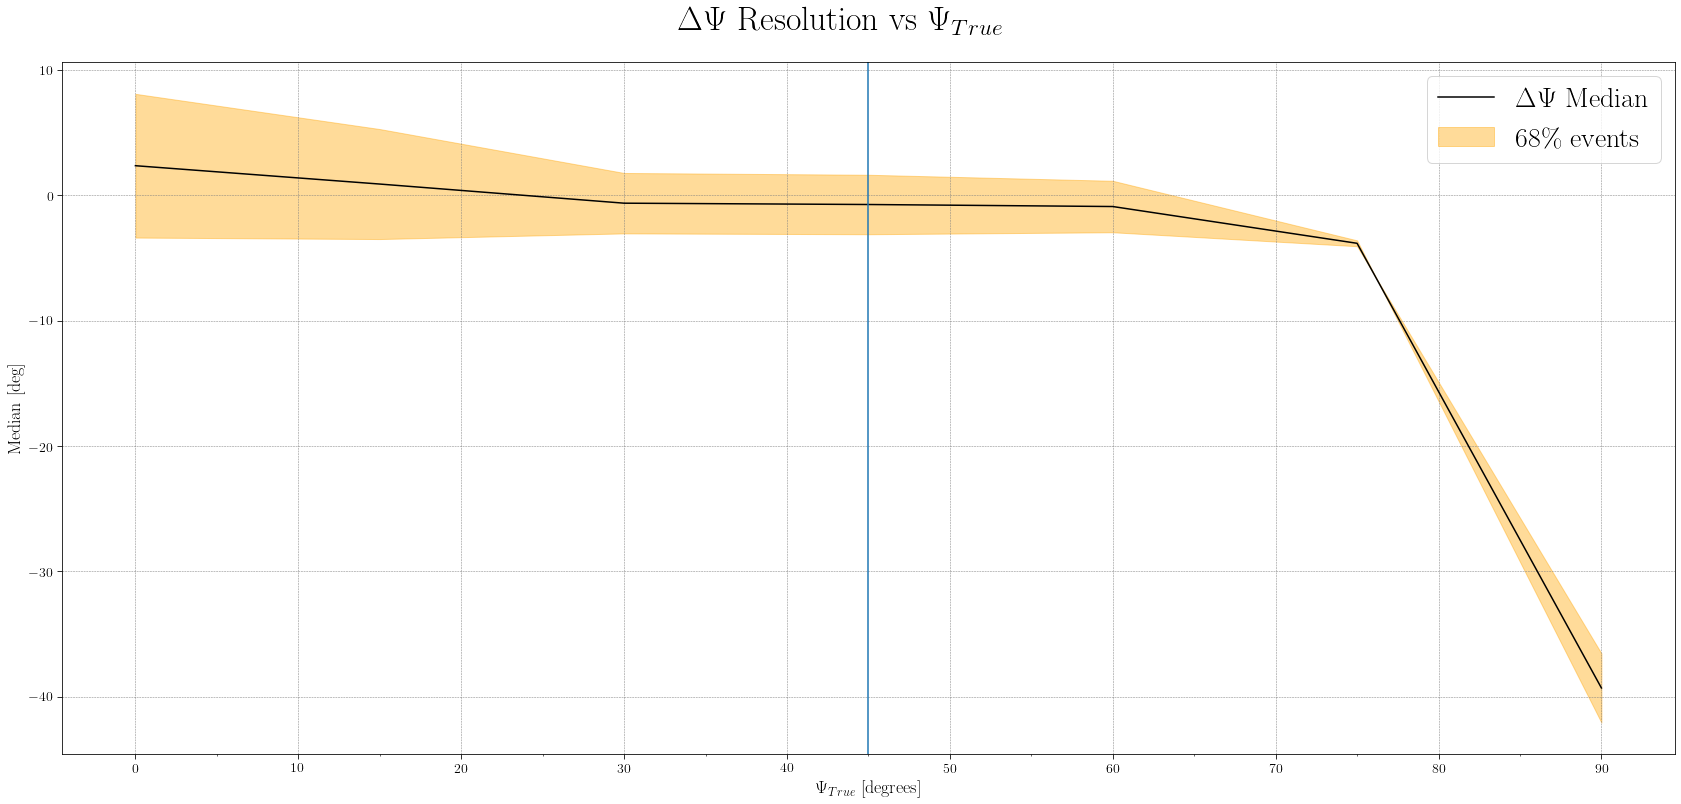

In [29]:
plt.rcParams.update({'font.size': 28})

snrMean = pandasToNumpy(polRF.SNR)[:,:8].mean(axis=1)

psiReco = pandasToNumpy(polRF.psiReco)
psiTrue = np.empty(psiReco.shape)
for pair in range(8):
    psiTrue[:,pair] = pandasToNumpy(polRF.runNumber)
deltaPsi = psiReco-psiTrue
fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=91,binSize=15, xResolution=15, xCutoff=0)
plt.axvline(45)
major_ticks = np.arange(0, 100, 10)
minor_ticks = np.arange(0, 90, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)



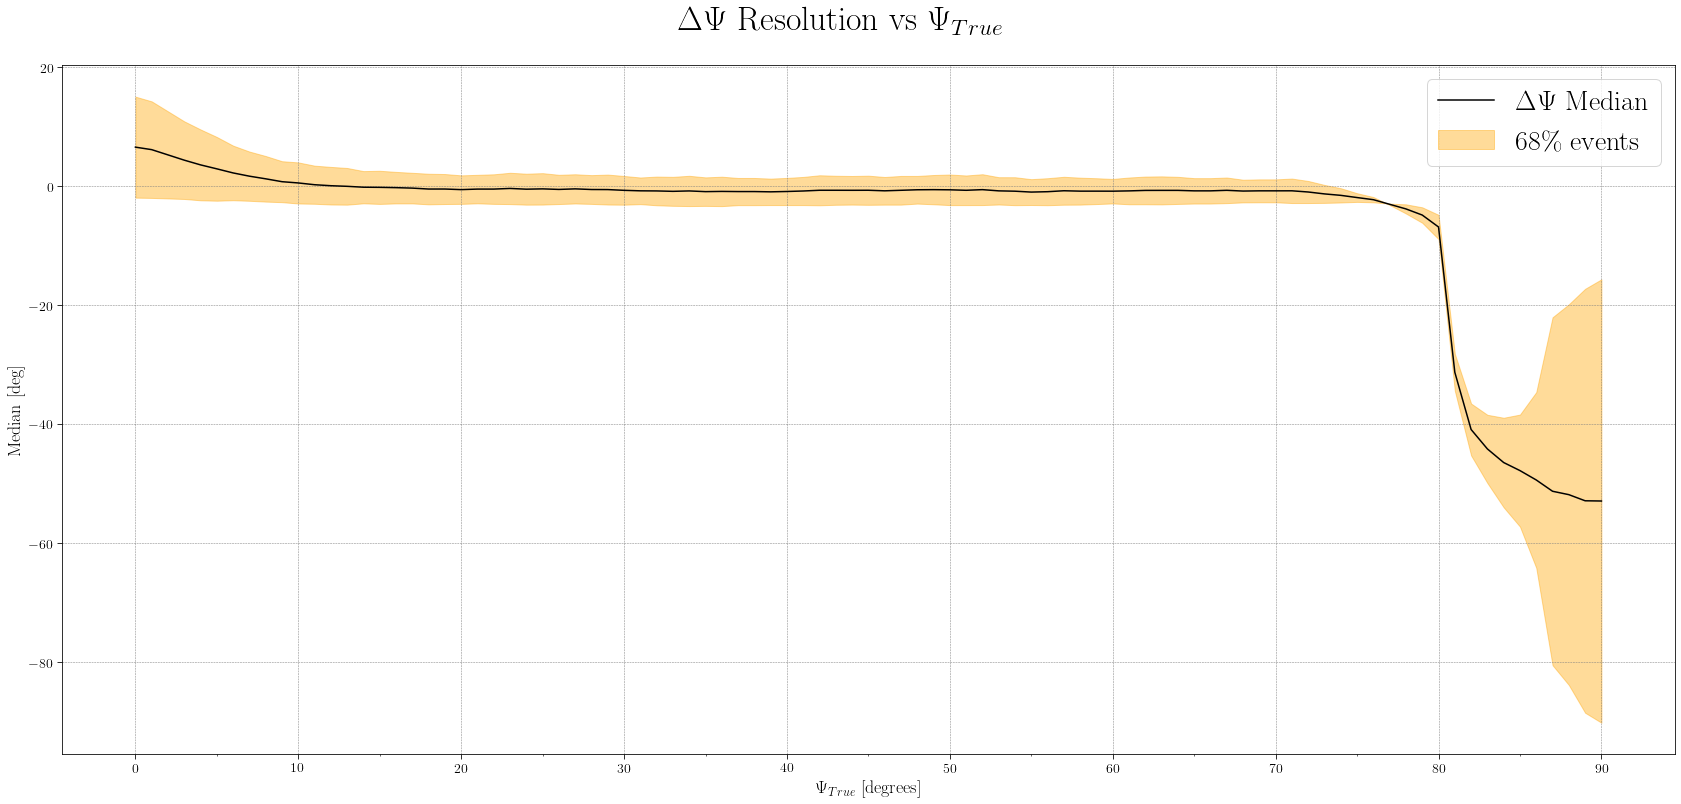

In [30]:
snrMean = pandasToNumpy(polRF.SNR).mean(axis=1)

psiReco = pandasToNumpy(polRF.psiReco[snrMean>5])
psiTrue = np.empty(psiReco.shape)
for pair in range(8):
    psiTrue[:,pair] = pandasToNumpy(polRF.runNumber[snrMean>5])
deltaPsi = psiReco-psiTrue
fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=91,binSize=1, xResolution=1, xCutoff=0)
# plt.axvline(45)
major_ticks = np.arange(0, 100, 10)
minor_ticks = np.arange(0, 90, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

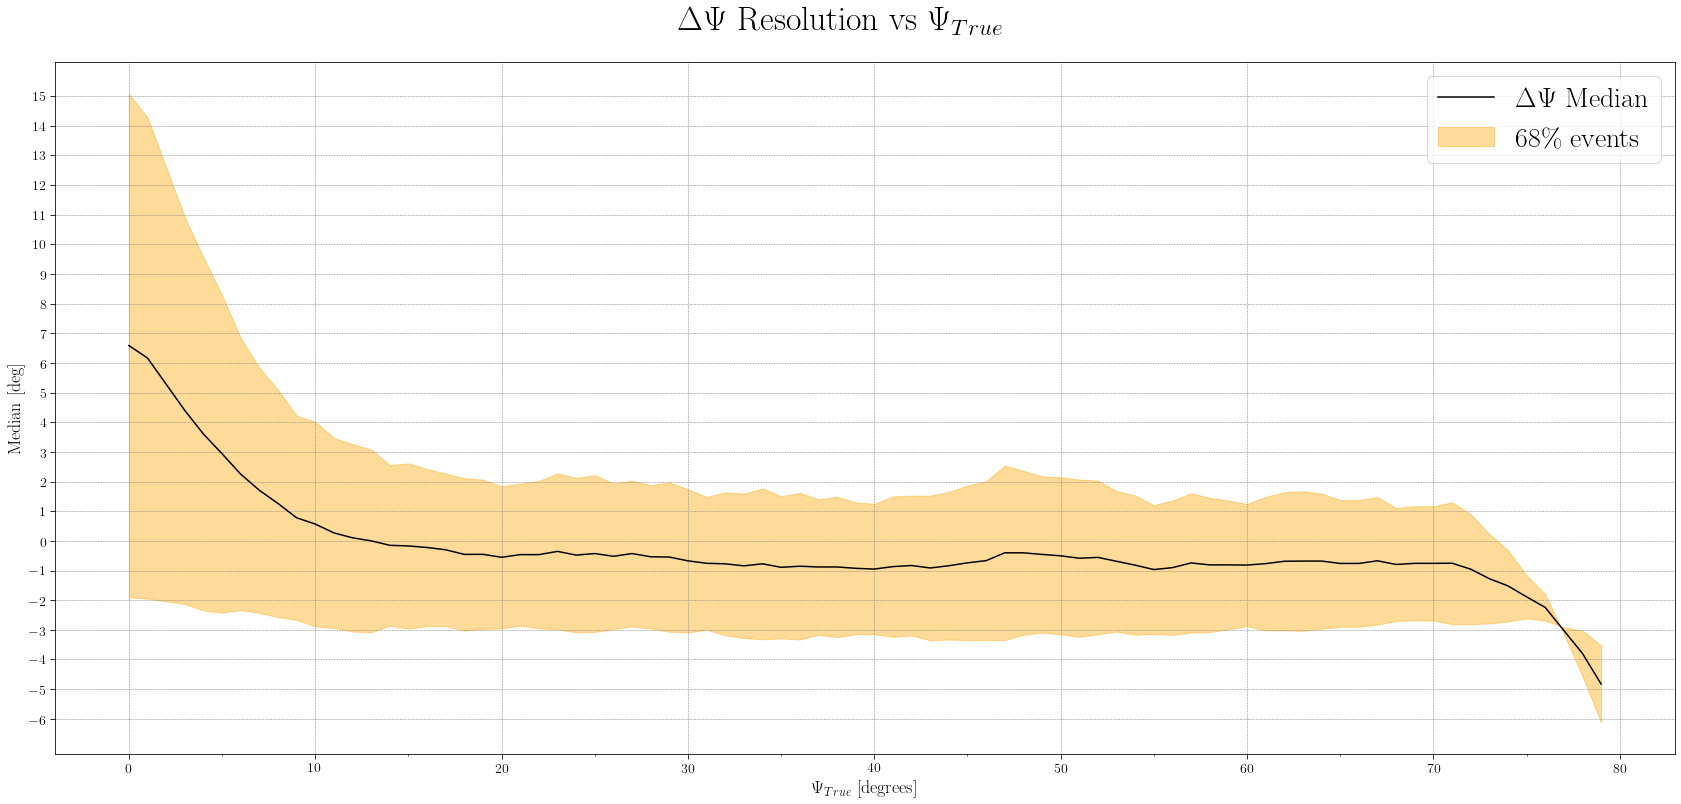

In [31]:
snrMean = pandasToNumpy(polRF.SNR).max(axis=1)

psiReco = pandasToNumpy(polRF.psiReco[snrMean>10])
psiTrue = np.empty(psiReco.shape)
for pair in range(8):
    psiTrue[:,pair] = pandasToNumpy(polRF.runNumber[snrMean>10])
deltaPsi = psiReco-psiTrue
fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=80,binSize=1, xResolution=1, xCutoff=0)
# plt.axvline(45)
major_ticks = np.arange(0, 90, 10)
minor_ticks = np.arange(0, 80, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(np.arange(-6,16,1))

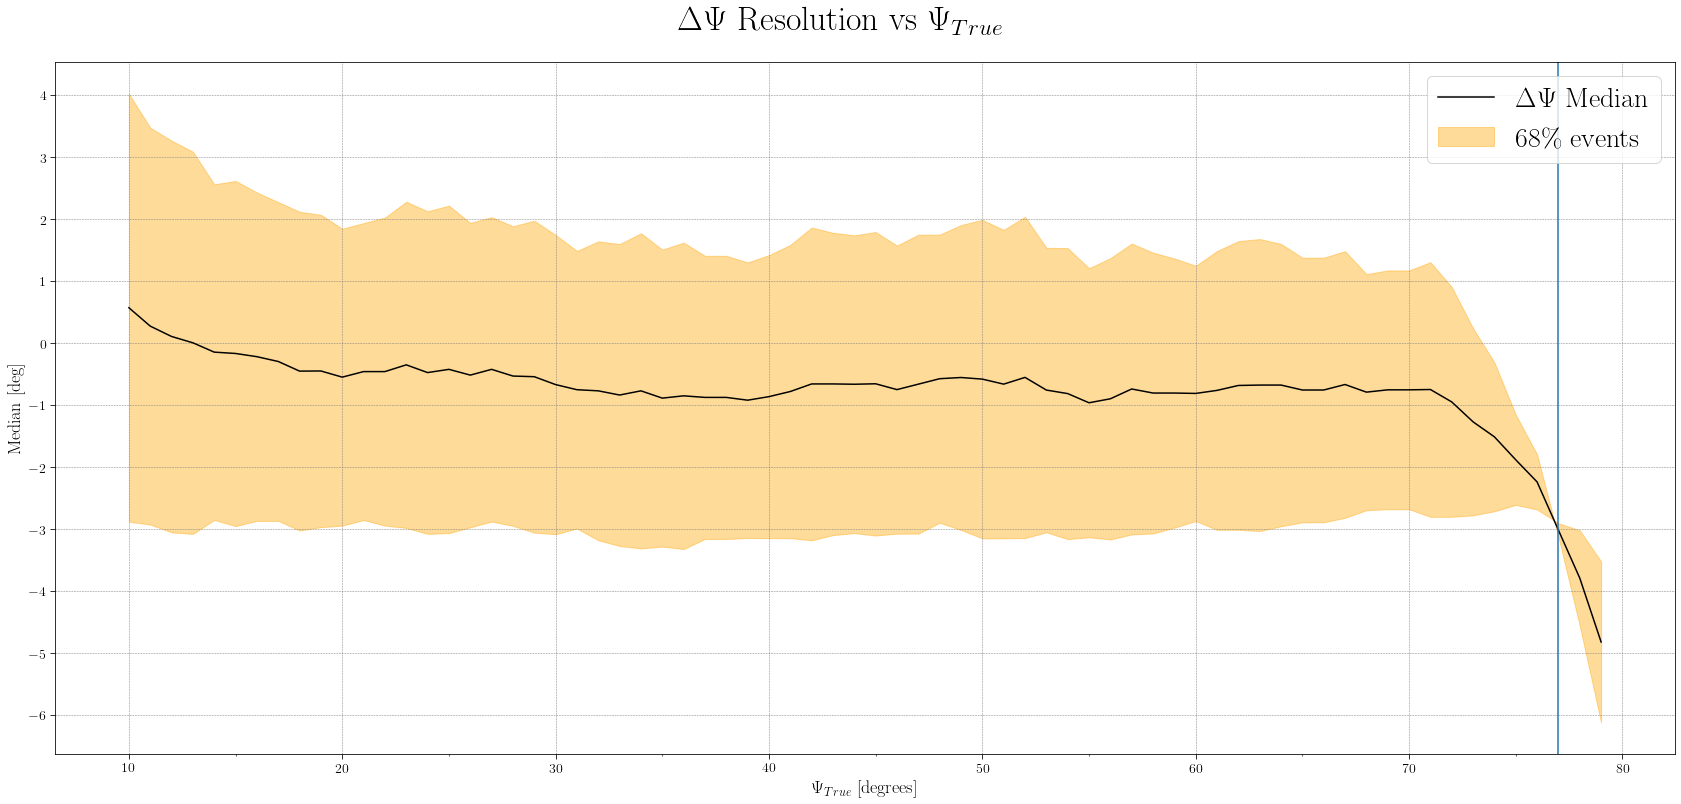

In [32]:
psiReco = pandasToNumpy(polRF.psiReco)
psiTrue = np.empty(psiReco.shape)
for pair in range(8):
    psiTrue[:,pair] = pandasToNumpy(polRF.runNumber)
deltaPsi = psiReco-psiTrue
fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=80,binSize=1, xResolution=1, xCutoff=10)
plt.axvline(77)
major_ticks = np.arange(10, 90, 10)
minor_ticks = np.arange(10, 80, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(np.arange(-6,5,1))

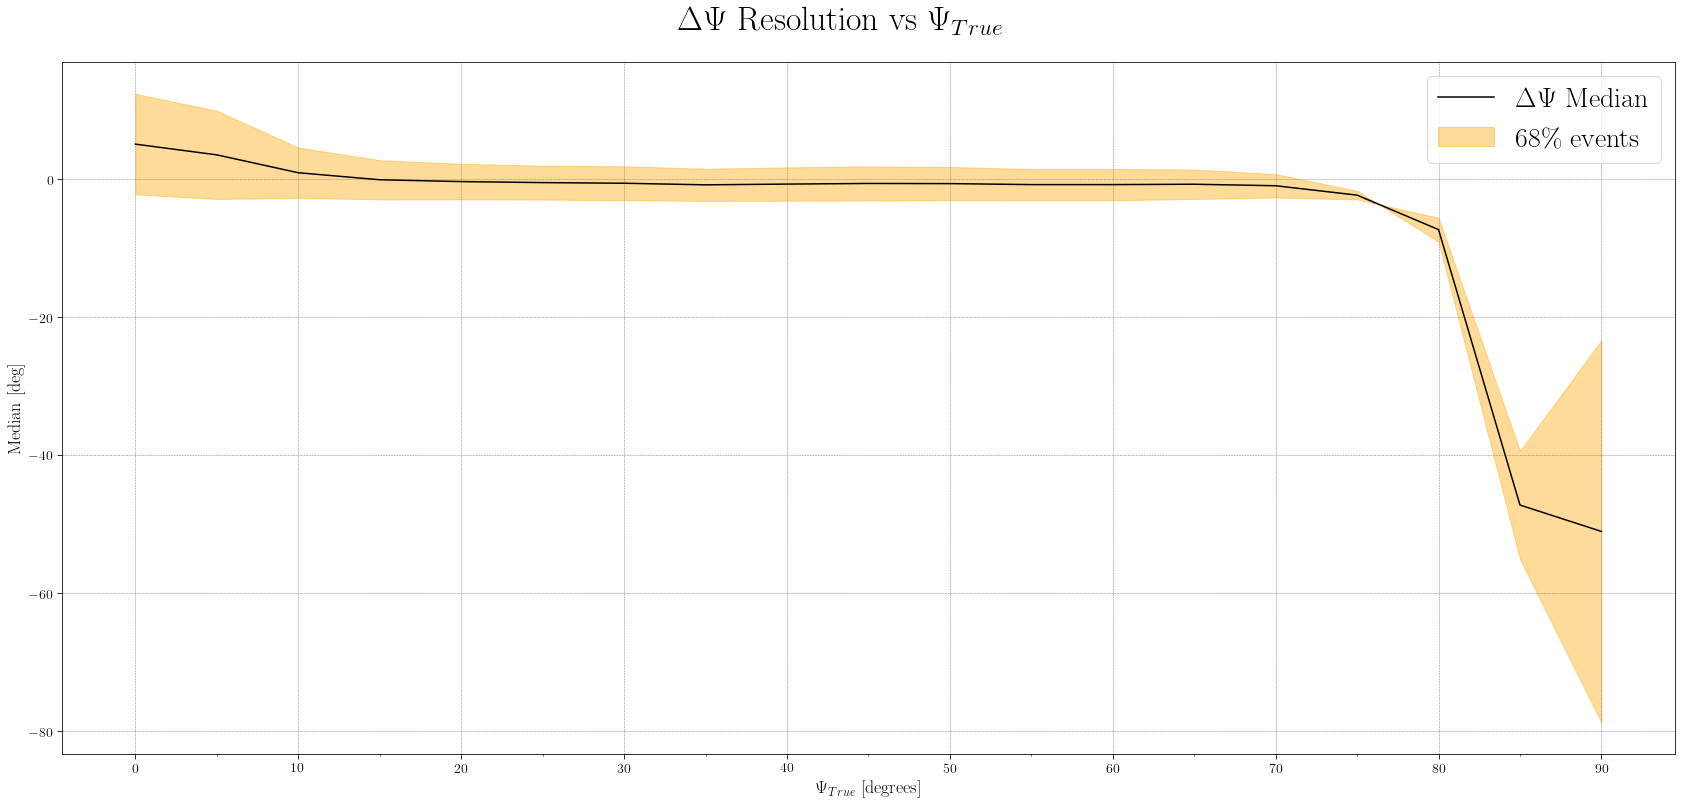

In [33]:
psiReco = pandasToNumpy(polRF.psiReco)
psiTrue = np.empty(psiReco.shape)
for pair in range(8):
    psiTrue[:,pair] = pandasToNumpy(polRF.runNumber)
deltaPsi = psiReco-psiTrue
fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=91,binSize=5, xResolution=5, xCutoff=0)
# plt.axvline(45)
major_ticks = np.arange(0, 100, 10)
minor_ticks = np.arange(0, 90, 5)
ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

(array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.]),
 [Text(0, -100.0, '$\\mathdefault{−100}$'),
  Text(0, -80.0, '$\\mathdefault{−80}$'),
  Text(0, -60.0, '$\\mathdefault{−60}$'),
  Text(0, -40.0, '$\\mathdefault{−40}$'),
  Text(0, -20.0, '$\\mathdefault{−20}$'),
  Text(0, 0.0, '$\\mathdefault{0}$'),
  Text(0, 20.0, '$\\mathdefault{20}$'),
  Text(0, 40.0, '$\\mathdefault{40}$')])

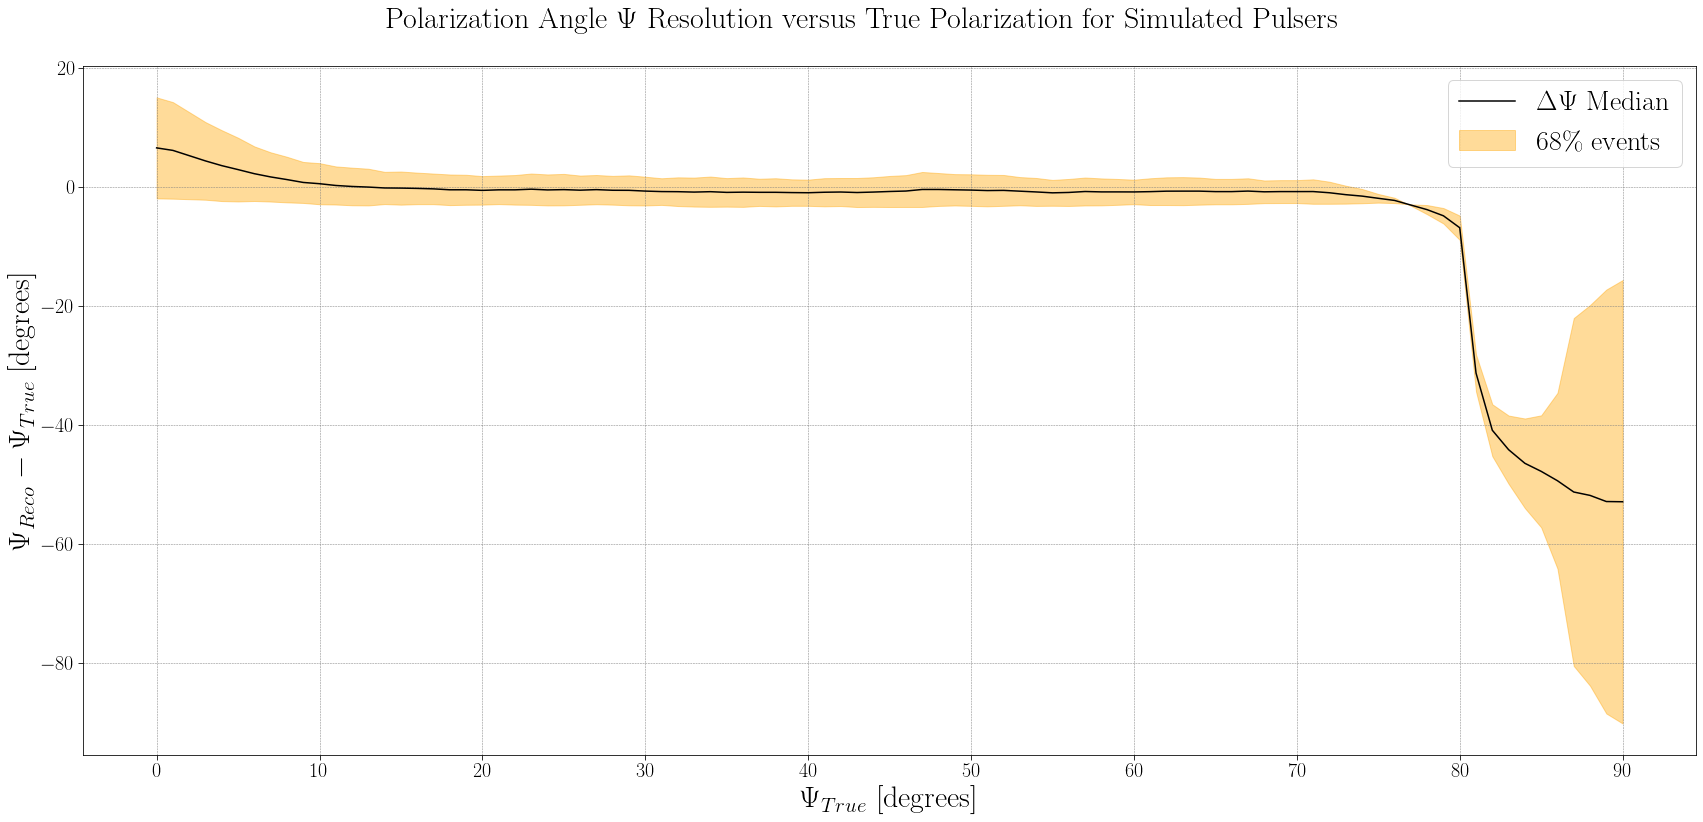

In [60]:
snrMean = pandasToNumpy(polRF.SNR).max(axis=1)

psiReco = pandasToNumpy(polRF.psiReco[snrMean>10])
psiTrue = np.empty(psiReco.shape)
for pair in range(8):
    psiTrue[:,pair] = pandasToNumpy(polRF.runNumber[snrMean>10])
deltaPsi = psiReco-psiTrue
fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=91,binSize=1, xResolution=1, xCutoff=0)
# plt.axvline(45)
major_ticks = np.arange(0, 100, 10)
minor_ticks = np.arange(0, 80, 5)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(np.arange(-6,16,1))

labelFontsize = 30
plt.suptitle("Polarization Angle $\\Psi$ Resolution versus True Polarization for Simulated Pulsers", fontsize=labelFontsize)
plt.ylabel("$\\Psi_{Reco} - \\Psi_{True}$ [degrees]", fontsize=labelFontsize)
plt.xlabel("$\\Psi_{True}$ [degrees]", fontsize=labelFontsize)
plt.xticks(major_ticks,fontsize=20)
plt.yticks(fontsize=20)

([<matplotlib.axis.YTick at 0x2b8f48671c80>,
 [Text(0, -5.0, '$\\mathdefault{−5.0}$'),
  Text(0, -2.5, '$\\mathdefault{−2.5}$'),
  Text(0, 0.0, '$\\mathdefault{0.0}$'),
  Text(0, 2.5, '$\\mathdefault{2.5}$'),
  Text(0, 5.0, '$\\mathdefault{5.0}$'),
  Text(0, 7.5, '$\\mathdefault{7.5}$'),
  Text(0, 10.0, '$\\mathdefault{10.0}$'),
  Text(0, 12.5, '$\\mathdefault{12.5}$'),
  Text(0, 15.0, '$\\mathdefault{15.0}$'),
  Text(0, 17.5, '$\\mathdefault{17.5}$'),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

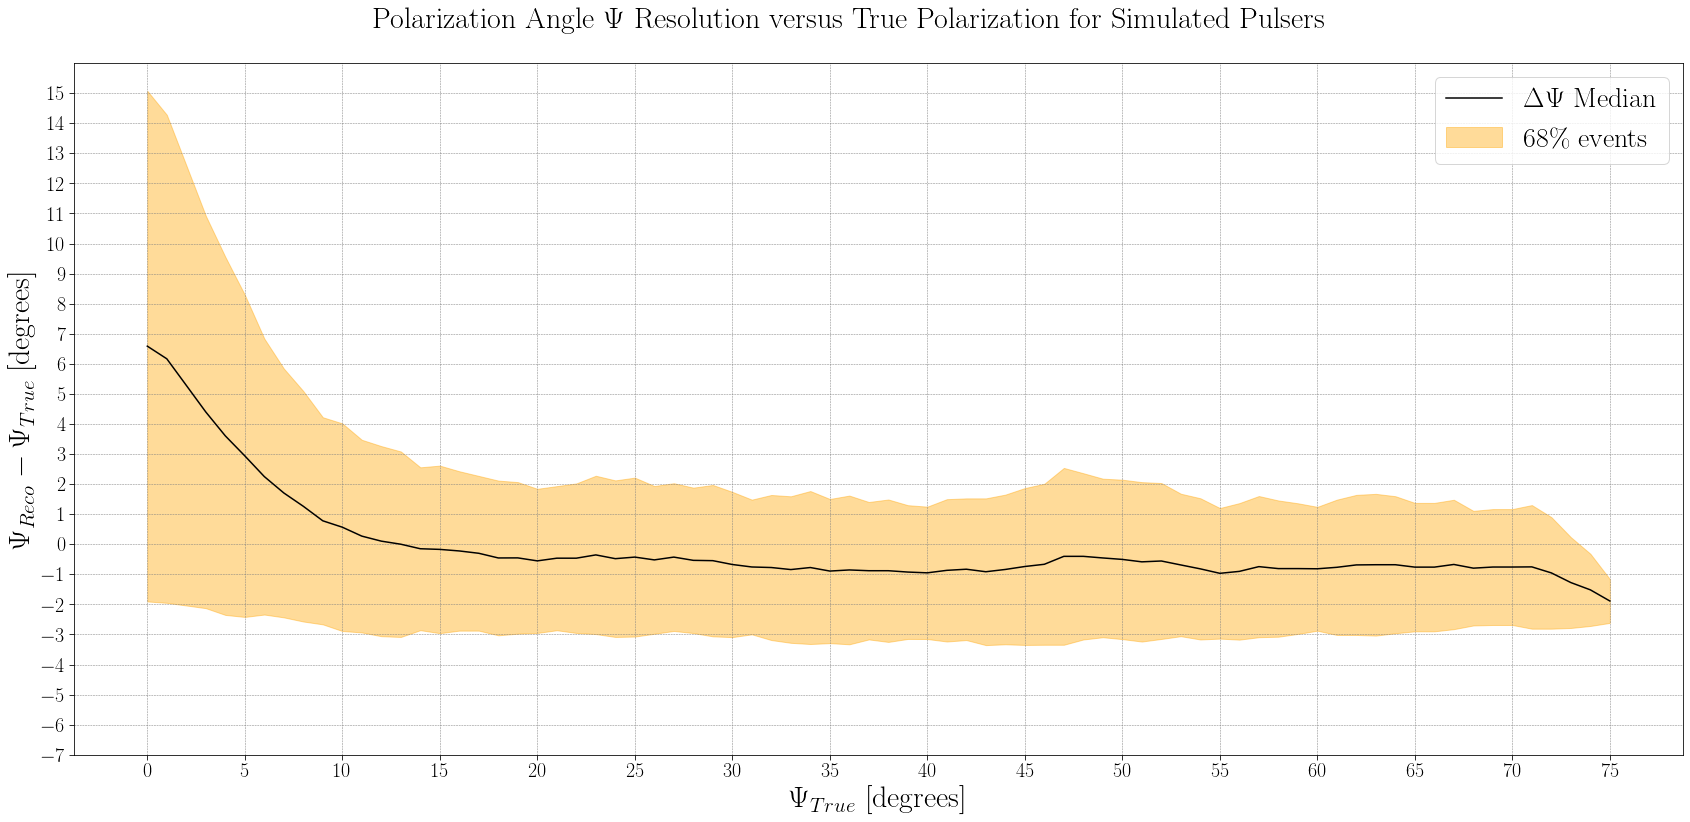

In [61]:
snrMean = pandasToNumpy(polRF.SNR).max(axis=1)

psiReco = pandasToNumpy(polRF.psiReco[snrMean>10])
psiTrue = np.empty(psiReco.shape)
for pair in range(8):
    psiTrue[:,pair] = pandasToNumpy(polRF.runNumber[snrMean>10])
deltaPsi = psiReco-psiTrue
fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=76,binSize=1, xResolution=1, xCutoff=0)
# plt.axvline(45)
major_ticks = np.arange(0, 80, 5)
minor_ticks = np.arange(0, 80, 5)
# ax.set_xticks(major_ticks, fontsize=30)
# ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(np.arange(-6,16,1))

labelFontsize = 30
plt.suptitle("Polarization Angle $\\Psi$ Resolution versus True Polarization for Simulated Pulsers", fontsize=labelFontsize)
plt.ylabel("$\\Psi_{Reco} - \\Psi_{True}$ [degrees]", fontsize=labelFontsize)
plt.xlabel("$\\Psi_{True}$ [degrees]", fontsize=labelFontsize)
plt.xticks(major_ticks, fontsize=20)
plt.yticks(np.arange(-7,16,1), fontsize=20)

(array([-100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.]),
 [Text(0, -100.0, '$\\mathdefault{−100}$'),
  Text(0, -80.0, '$\\mathdefault{−80}$'),
  Text(0, -60.0, '$\\mathdefault{−60}$'),
  Text(0, -40.0, '$\\mathdefault{−40}$'),
  Text(0, -20.0, '$\\mathdefault{−20}$'),
  Text(0, 0.0, '$\\mathdefault{0}$'),
  Text(0, 20.0, '$\\mathdefault{20}$')])

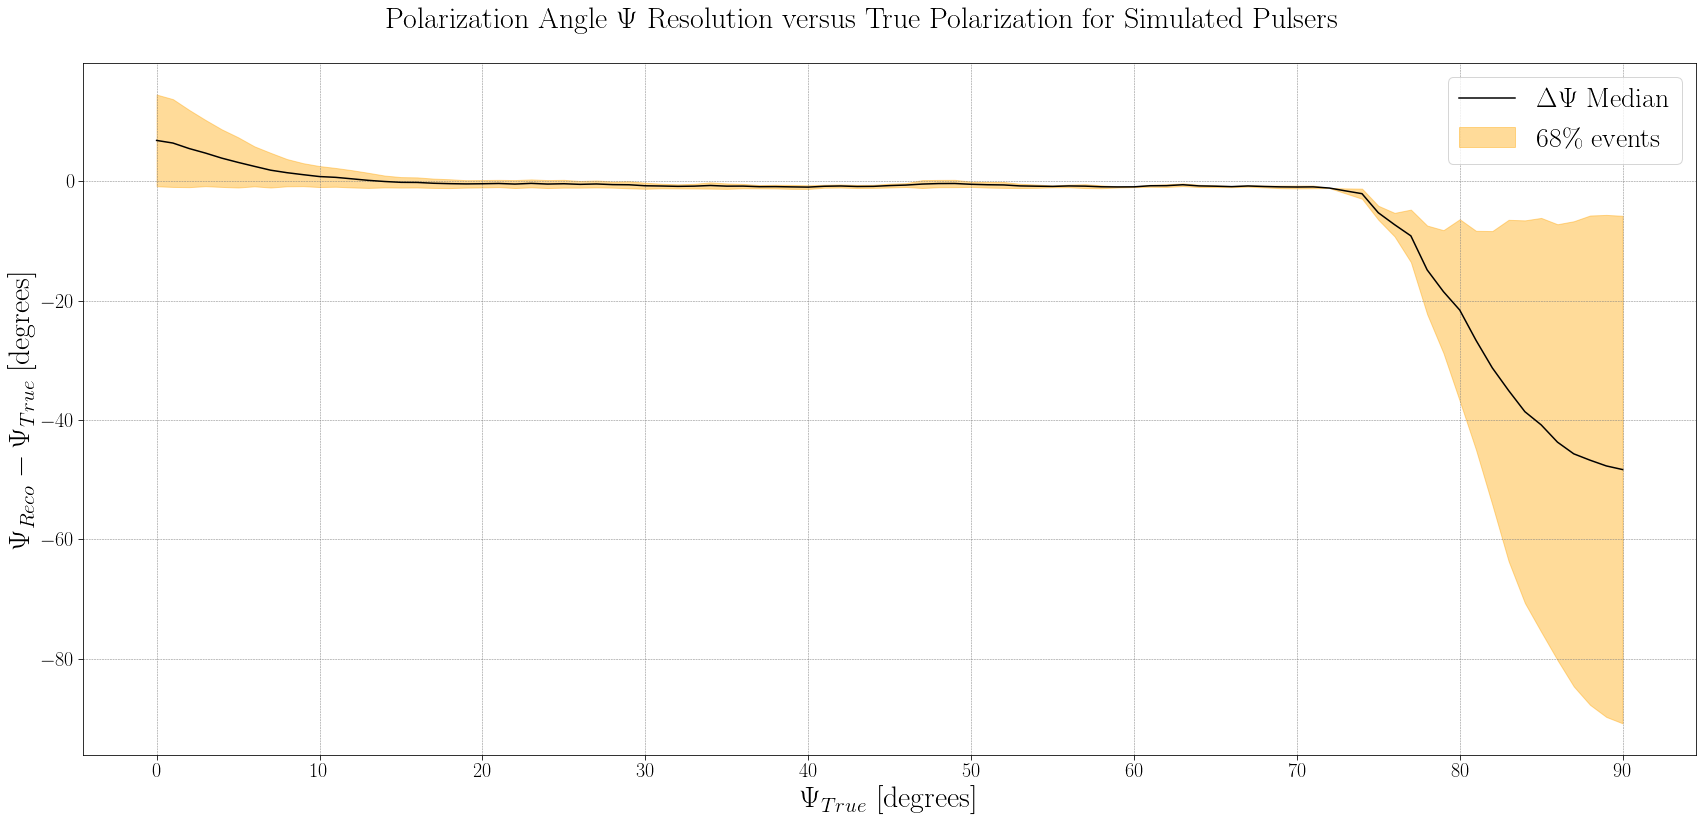

In [55]:
snrMean = pandasToNumpy(polRF.SNR).max(axis=1)

psiReco = pandasToNumpy(polRF.psiReco[snrMean>10]).mean(axis=1)
psiTrue = np.empty(psiReco.shape)
for pair in range(8):
    psiTrue[:] = pandasToNumpy(polRF.runNumber[snrMean>10])
deltaPsi = psiReco-psiTrue
fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=91,binSize=1, xResolution=1, xCutoff=0)
# plt.axvline(45)
major_ticks = np.arange(0, 100, 10)
minor_ticks = np.arange(0, 80, 5)
# ax.set_xticks(major_ticks)
# ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(np.arange(-6,16,1))

labelFontsize = 30
plt.suptitle("Polarization Angle $\\Psi$ Resolution versus True Polarization for Simulated Pulsers", fontsize=labelFontsize)
plt.ylabel("$\\Psi_{Reco} - \\Psi_{True}$ [degrees]", fontsize=labelFontsize)
plt.xlabel("$\\Psi_{True}$ [degrees]", fontsize=labelFontsize)
plt.xticks(major_ticks,fontsize=20)
plt.yticks(fontsize=20)

([<matplotlib.axis.YTick at 0x2b8f48a4ee10>,
 [Text(0, -10.0, '$\\mathdefault{−10}$'),
  Text(0, -5.0, '$\\mathdefault{−5}$'),
  Text(0, 0.0, '$\\mathdefault{0}$'),
  Text(0, 5.0, '$\\mathdefault{5}$'),
  Text(0, 10.0, '$\\mathdefault{10}$'),
  Text(0, 15.0, '$\\mathdefault{15}$'),
  Text(0, 20.0, '$\\mathdefault{20}$'),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

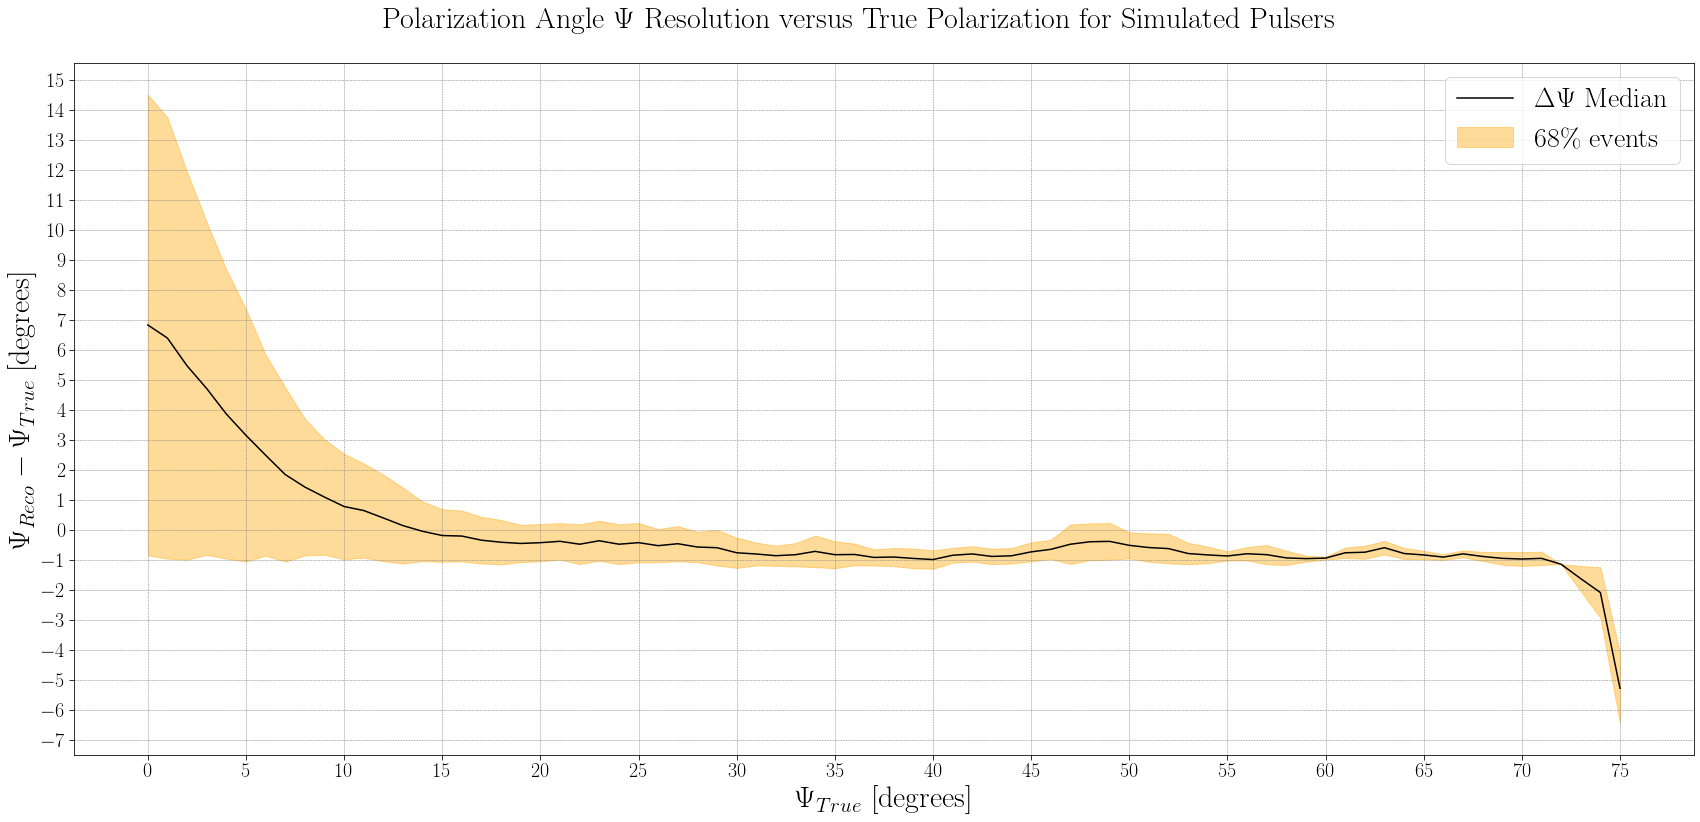

In [59]:
snrMean = pandasToNumpy(polRF.SNR).max(axis=1)

psiReco = pandasToNumpy(polRF.psiReco[snrMean>10]).mean(axis=1)
psiTrue = np.empty(psiReco.shape)
for pair in range(8):
    psiTrue[:] = pandasToNumpy(polRF.runNumber[snrMean>10])
deltaPsi = psiReco-psiTrue
fig, ax = singleDeltaVsTrueValue(deltaPsi, psiTrue, label1='$\\Delta \\Psi$ Median', xMax=76,binSize=1, xResolution=1, xCutoff=0)
# plt.axvline(45)
major_ticks = np.arange(0, 80, 5)
minor_ticks = np.arange(0, 80, 5)
# ax.set_xticks(major_ticks, fontsize=30)
# ax.set_xticks(minor_ticks, minor=True)
# ax.set_yticks(np.arange(-6,16,1))

labelFontsize = 30
plt.suptitle("Polarization Angle $\\Psi$ Resolution versus True Polarization for Simulated Pulsers", fontsize=labelFontsize)
plt.ylabel("$\\Psi_{Reco} - \\Psi_{True}$ [degrees]", fontsize=labelFontsize)
plt.xlabel("$\\Psi_{True}$ [degrees]", fontsize=labelFontsize)
plt.xticks(major_ticks, fontsize=20)
plt.yticks(np.arange(-7,16,1), fontsize=20)

In [ ]:
# #Perform second round of cuts for timing window.
# #Initialize Mask
# mask = np.ones(len(polCut)).astype(bool)

# for i in range(3):
#     mask *= pandasToNumpy(polCut.timingDifferenceMeasured)[:,i] > timingWindows[i,0]*1e-9
#     mask *= pandasToNumpy(polCut.timingDifferenceMeasured)[:,i] < timingWindows[i,1]*1e-9

# polCut2 = polCut.loc[mask]
# polCut2_removedEvents = polCut.loc[np.invert(mask)]
# len(polCut2)

In [ ]:
# fig, ax = plotDeltaT(polCut2, snrCutoff=5, bins=range(-100,100,5))

# timingWindows = np.array([[-20,-10],[20,50],[40,65]])
# # travelTime = np.linalg.norm(rx-tx,axis=1)/c*n*1e9

# # combinations = []
# # for combination in itertools.combinations(timingChannels, 2):
# #     combinations.append(combination)

# directDeltaT = np.array([-43.57542622,  41.58121579,  85.15664201])

# for i in range(3):
#     for j in range(2):
#         ax[0,i].axvline(timingWindows[i,j], color='black', linestyle='--', label = str(timingWindows[i,j]))
#     ax[0,i].legend()
#     ax[1,i].axvline(directDeltaT[i], color='black', label=str(directDeltaT[i]))
#     ax[1,i].legend()

In [ ]:
# #Perform third round of cuts for timing window to explore extra population in measure 02
# #Initialize Mask
# mask = np.ones(len(polCut)).astype(bool)


# mask *= pandasToNumpy(polCut.timingDifferenceMeasured)[:,0] > -42*1e-9
# mask *= pandasToNumpy(polCut.timingDifferenceMeasured)[:,0] < -28*1e-9

# polCut3 = polCut.loc[mask]
# polCut3_removedEvents = polCut.loc[np.invert(mask)]
# len(polCut3)

In [ ]:
# fig, ax = plotDeltaT(polCut3, snrCutoff=5, bins=range(-100,100,5))

# timingWindows = np.array([[-20,-10],[20,50],[40,65]])

# # for i in range(3):
# #     for j in range(2):
# #         ax[0,i].axvline(timingWindows[i,j], color='black', linestyle='--', label = str(timingWindows[i,j]))
# #     ax[0,i].legend()

# ax[0,0].axvline(-42,color='black')
# ax[0,0].axvline(-28,color='black')

In [ ]:
# from matplotlib.backends.backend_pdf import PdfPages
# pp3 = PdfPages('population02Events.pdf')
# keptRuns = np.unique(pandasToNumpy(polCut3.runNumber)).astype(int)
# for run in keptRuns:
#     rawSrcFolder = "../ARA_Reconstruction/data/A"+str(station)+"/run_0"+str(int(run))
#     rawFilename = rawSrcFolder + "/event0"+str(int(run))+".root"
#     removedEvents = pandasToNumpy(polCut3.loc[polCut3.runNumber == run].eventNumber).astype(int)
    
#     print(rawFilename)
#     rawInputFile = ROOT.TFile.Open(rawFilename)
#     eventTree = rawInputFile.Get("eventTree")
#     rawEvent = ROOT.RawAtriStationEvent()
#     eventTree.SetBranchAddress("event",ROOT.AddressOf(rawEvent))
#     for evt in removedEvents:
#         eventTree.GetEntry(evt)
#         usefulEvent = ROOT.UsefulAtriStationEvent(rawEvent,ROOT.AraCalType.kLatestCalib)
#         fig, ax = util.plotRawWaveform(usefulEvent, runNumber=run, station = station)
#         pp3.savefig(fig)
#         plt.close()
        
# pp3.close()

In [ ]:
# #Generate list of events that pass the timing window cut, as well as fail the cut.
# #I have run numbers and event numbers.  I just need to loop through the root files and save the waveforms to a PDF.
# from matplotlib.backends.backend_pdf import PdfPages
# pp = PdfPages('keptA2Events.pdf')
# keptRuns = np.unique(pandasToNumpy(polCut2.runNumber)).astype(int)
# for run in keptRuns:
#     rawSrcFolder = "../ARA_Reconstruction/data/A"+str(station)+"/run_0"+str(int(run))
#     rawFilename = rawSrcFolder + "/event0"+str(int(run))+".root"
#     keptEvents = pandasToNumpy(polCut2.loc[polCut2.runNumber == run].eventNumber).astype(int)
    
#     print(rawFilename)
#     rawInputFile = ROOT.TFile.Open(rawFilename)
#     eventTree = rawInputFile.Get("eventTree")
#     rawEvent = ROOT.RawAtriStationEvent()
#     eventTree.SetBranchAddress("event",ROOT.AddressOf(rawEvent))
#     for evt in keptEvents:
#         eventTree.GetEntry(evt)
#         usefulEvent = ROOT.UsefulAtriStationEvent(rawEvent,ROOT.AraCalType.kLatestCalib)
#         fig, ax = util.plotRawWaveform(usefulEvent, runNumber=run, station = station)
#         print("Run: " + str(run) + ", Event: " + str(evt))
#         pp.savefig(fig)
#         plt.close()
        
# pp.close()

In [ ]:
# pp2 = PdfPages('cutA2Events.pdf')
# keptRuns = np.unique(pandasToNumpy(polCut2_removedEvents.runNumber)).astype(int)
# for run in keptRuns:
#     rawSrcFolder = "../ARA_Reconstruction/data/A"+str(station)+"/run_0"+str(int(run))
#     rawFilename = rawSrcFolder + "/event0"+str(int(run))+".root"
#     removedEvents = pandasToNumpy(polCut2_removedEvents.loc[polCut2_removedEvents.runNumber == run].eventNumber).astype(int)
    
#     print(rawFilename)
#     rawInputFile = ROOT.TFile.Open(rawFilename)
#     eventTree = rawInputFile.Get("eventTree")
#     rawEvent = ROOT.RawAtriStationEvent()
#     eventTree.SetBranchAddress("event",ROOT.AddressOf(rawEvent))
#     for evt in removedEvents:
#         eventTree.GetEntry(evt)
#         usefulEvent = ROOT.UsefulAtriStationEvent(rawEvent,ROOT.AraCalType.kLatestCalib)
#         fig, ax = util.plotRawWaveform(usefulEvent, runNumber=run, station = station)
#         pp2.savefig(fig)
        
# pp2.close()

In [ ]:
# plotDeltaT(pol, mask=np.array(pol.timingDifferenceExpected.to_numpy().tolist())[:,1]>-5000e-9, bins=range(-600,600,50))

In [ ]:
# plotDeltaT(pol, mask=np.array(pol.timingDifferenceExpected.to_numpy().tolist())[:,1]>-5000e-9, bins=range(-200,200,10))

In [ ]:
# plotDeltaT(pol, mask=np.array(pol.timingDifferenceExpected.to_numpy().tolist())[:,1]>-5000e-9, bins=range(-200,200,10), snrCutoff=5)

In [ ]:
# plotDeltaT(pol, bins=range(-200,200,10), snrCutoff=5)

In [ ]:
# plotDeltaT(pol, bins=range(-200,200,10), snrCutoff=5, mask=pol.pulserDepth.to_numpy() > 600)

In [ ]:
# plotDeltaT(pol, bins=range(-100,100,5), snrCutoff=5, mask=pol.pulserDepth.to_numpy() > 650)

In [ ]:
# plotDeltaT(pol, snrCutoff=5, mask=pol.pulserDepth.to_numpy() > 650)

In [ ]:
# pol.loc[(np.array(pol.timingDifferenceExpected.to_numpy().tolist())[:,0] < -5000e-9) & (np.array(pol.pulserDepth.to_numpy().tolist()) > 650)]

In [ ]:
# testMask = (np.array(pol.pulserDepth.to_numpy().tolist()) > 650) & np.all(np.array(pol.thetaReco.to_numpy().tolist())>90, axis=1)
# pol.loc[testMask]

In [ ]:
# plotDeltaT(pol, bins=range(-100,100,5), snrCutoff=5, mask=testMask)